In [1]:
import numpy as np
import pandas as pd
import quantecon as qe
from ast import literal_eval
from sklearn.ensemble import RandomForestRegressor

In [2]:
def creating_samples(samples_number, element):
    gen=0
    uniform_number = len(element)
    uniform_samples = (-qe.simplex_grid(len(element), 1)+1)/(len(element)-1)
    if samples_number > uniform_number:
        random_samples = np.random.rand((samples_number-uniform_number), len(element))
        for i in range(samples_number-uniform_number):
            random_samples[i] = np.around(random_samples[i]/sum(random_samples[i]), decimals = 3)
        sample = np.vstack((uniform_samples, random_samples))
    else:
        sample = uniform_samples[:samples_number]
    samples = []
    for i in range(samples_number):
        samples.append(list(sample[i]))
    samples = np.array(samples)
    generation = []
    for i in range (samples_number):
            generation.append(gen)

    ID = np.arange(1, (samples_number+1))

    data = {'ID' : ID, 'Elements': [element], 'Generation': generation}
    df = pd.DataFrame(data=data, index = np.arange(samples_number))
    df = pd.concat([df, pd.DataFrame(([[i] for i in samples]), columns = ['Position'])], axis = 1)
    df.to_csv("Result/Initial Population.txt", sep='\t', index=False, mode='w')
    return df

In [6]:
#Loading data and fitting
df_old = pd.read_csv('Data/AuIrOsPdPtReRhRu_0.60_compositions_and_targets.csv')
X_columns_old = ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']
x_old = df_old[X_columns_old].to_numpy()
y_old = df_old['current_over_capacitance'].to_numpy()

#Rndom Forest Regression
reg = RandomForestRegressor(n_estimators = 1024,
                           bootstrap = True,
                           max_depth = None,
                           max_features = 'auto',
                           min_samples_leaf = 1,
                           min_samples_split = 2,
                           oob_score = True)
reg = reg.fit(x_old, y_old)

In [7]:
#Determine the best position
grid = qe.simplex_grid(3, 1000)/1000
zeros = np.zeros(len(grid)).reshape(-1,1)

grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = pd.DataFrame(grid,columns=[X_columns_old])
grid['Activity'] = reg.predict(grid.to_numpy())
best_grid = grid.iloc[np.argmin(grid['Activity'])][0:3].to_numpy()

In [9]:
grid

,Pt,Pd,Au,Ru,Rh,Ir,Re,Os,Activity
0,0.000,0.000,1.000,0.0,0.0,0.0,0.0,0.0,-0.233534
1,0.000,0.001,0.999,0.0,0.0,0.0,0.0,0.0,-0.233534
2,0.000,0.002,0.998,0.0,0.0,0.0,0.0,0.0,-0.233534
3,0.000,0.003,0.997,0.0,0.0,0.0,0.0,0.0,-0.233519
4,0.000,0.004,0.996,0.0,0.0,0.0,0.0,0.0,-0.233519
...,...,...,...,...,...,...,...,...,...
501496,0.998,0.001,0.001,0.0,0.0,0.0,0.0,0.0,-0.883276
501497,0.998,0.002,0.000,0.0,0.0,0.0,0.0,0.0,-0.883276
501498,0.999,0.000,0.001,0.0,0.0,0.0,0.0,0.0,-0.883276
501499,0.999,0.001,0.000,0.0,0.0,0.0,0.0,0.0,-0.883276


In [8]:
print(best_grid, grid.iloc[np.argmin(grid['Activity'])]['Activity'])

[0.397 0.294 0.309] -1.0405408984374978


In [10]:
#Making Class
class pso:
    def __init__ (self, data, step, target = np.array([0.333, 0.333, 0.333])):
        self.datalog = data
        #Reading "Elements" columns from string to list
        self.datalog['Elements'] = self.datalog["Elements"].apply(lambda x: literal_eval(x))
        
        #Select latest generation
        self.generation = self.datalog['Generation'].max()
        
        #Creating np.array of "Position" column and dropping the string type "Position" column
        self.position = []
        for i in range(self.datalog['ID'].max()):
            self.position.append(list(np.fromstring(self.datalog['Position'][i][1:-1], dtype=float, sep=' ')))
        self.position = np.array(self.position)
        self.datalog = self.datalog.drop(columns=['Position'])
        self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.position]), columns = ['Position'])], axis = 1)
        
        #Creating "Velocity" column for the "0" generation
        if self.generation == 0:
            self.velocity = np.around((-(self.position - target)/step), decimals = 3)
            self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.velocity]), columns = ['Velocity'])], axis = 1)

        
        #Creating blank "Activity" column
        self.datalog = pd.concat([self.datalog, pd.DataFrame(columns = ['Activity'], index = np.arange(self.datalog['ID'].max()))], axis = 1)      

        #Filling the "Activity" column with RFR
        self.f_activity(self.datalog)
            
        #Creating dataframe of the latest generation
        self.working_generation = self.datalog.loc[self.datalog['Generation']==self.generation]
    
    
            
    def move(self, factor_1, factor_2, factor_3, mutation_rate, mutation_prob):
        #Performing move function  
        self.generation += 1
        self.working_generation['Generation'] += 1
        
        #Creating new velocity
        for i in range(len(self.working_generation)):
            new_velocity = -(factor_1 * population.working_generation.at[i, 'Velocity'] + 
                        factor_2 * population.delta_gen_best((i+1), 'Activity') * population.delta_gen_best((i+1), 'Position') + 
                        factor_3 * population.delta_individual_best((i+1), 'Activity') * population.delta_individual_best((i+1), 'Position'))
            #Mutation process
            self.working_generation.at[i,'Velocity'] = self.mutate(new_velocity, mutation_rate, mutation_prob)
        #Normalization
        self.normalize_velocity()
            
        #Changing position
        for i in range(len(self.working_generation)):    
            new_position = self.working_generation['Position'][i] + self.working_generation['Velocity'][i]
            self.working_generation.at[i,'Position'] = np.around(new_position, decimals = 3)
            
            
            
        """#Checking whether the new position cross the boundaries (UNFINISHED)
        if new_position.max() > 1 or new_position.min() < 0:
            new_position = self.working_generation['Position'][i] - self.working_generation['Velocity'][i]*size
        self.working_generation.at[i,'Position'] = np.around(new_position, decimals = 3)"""
        
        
        #Filling the "Activity" column with RFR
        self.f_activity(self.working_generation)
        
        #Concating the tables
        self.datalog = pd.concat([self.datalog, self.working_generation])
        self.datalog = self.datalog.reset_index(drop=True)
        self.store_datalog()
        return
    
    def f_activity(self, dataframe):
        global reg
        a = [0, 0, 0, 0, 0]
        for i in range(len(dataframe)):
            dataframe.at[i, 'Activity'] = float(reg.predict(np.reshape((np.hstack((dataframe.at[i, 'Position'], a))), (1, -1))))
        return 

    def store_datalog(self):
        self.datalog.to_csv("Result/Initial Population_gen "+str(self.generation)+".txt", sep='\t', index=False, mode='w')
        return
    
    def normalize_velocity(self):
        for i in range(len(self.working_generation)):
            self.working_generation.at[i, 'Velocity'] = self.working_generation.at[i, 'Velocity'] - (sum(self.working_generation.at[i, 'Velocity'])/len(self.working_generation['Elements'][0]))
            self.working_generation.at[i, 'Velocity'] = np.around(self.working_generation.at[i, 'Velocity'], decimals= 3)
        return
    
    def normalize_position(self):
        for i in range(len(self.working_generation)):
            self.working_generation.at[i, 'Position'] = self.working_generation.at[i, 'Position']/(sum(self.working_generation.at[i, 'Position']))
            self.working_generation.at[i, 'Position'] = np.around(self.working_generation.at[i, 'Position'], decimals= 3)
        return 
    
    
    def gen_best(self):
        return self.working_generation.loc[np.argmin(self.working_generation['Activity'])]
           
   
    def individual_best(self, ID):
        self.i_data = self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
        return self.i_data.loc[np.argmin(self.i_data['Activity'])]
    
    def delta_gen_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.gen_best()[parameter]
    
    def delta_individual_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.individual_best(ID)[parameter]      
    
    def mutate(self, new_velocity, mutation_rate, mutation_prob):
        mutated_velocity = []
        for i in range(len(new_velocity)):
            mutation = np.random.rand()
            step_size_i = 1
            if mutation < mutation_prob:
                step_size_i = np.random.uniform((1-mutation_rate), (1+mutation_rate))
            mutated_velocity.append(new_velocity[i]*step_size_i)
        mutated_velocity = np.array(mutated_velocity)
        return mutated_velocity
    
    def individual_log(self, ID):
        return self.datalog[self.datalog['ID']==ID].reset_index(drop=True)

In [11]:
samples_number = 6
element = ['Pt', 'Pd', 'Au']
creating_samples(samples_number, element)

,ID,Elements,Generation,Position
0,1,"[Pt, Pd, Au]",0,"[0.5, 0.5, 0.0]"
1,2,"[Pt, Pd, Au]",0,"[0.5, 0.0, 0.5]"
2,3,"[Pt, Pd, Au]",0,"[0.0, 0.5, 0.5]"
3,4,"[Pt, Pd, Au]",0,"[0.406, 0.368, 0.225]"
4,5,"[Pt, Pd, Au]",0,"[0.115, 0.477, 0.408]"
5,6,"[Pt, Pd, Au]",0,"[0.229, 0.16, 0.611]"


In [18]:
step = 10
target = np.array([0.333, 0.333, 0.333])
population = pso(pd.read_csv('Result/Initial Population.txt', sep='\t'), step, target)

In [13]:
population.datalog

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",0,"[0.5, 0.5, 0.0]","[-0.017, -0.017, 0.033]",-0.933614
1,2,"[Pt, Pd, Au]",0,"[0.5, 0.0, 0.5]","[-0.017, 0.033, -0.017]",-0.911367
2,3,"[Pt, Pd, Au]",0,"[0.0, 0.5, 0.5]","[0.033, -0.017, -0.017]",-0.274401
3,4,"[Pt, Pd, Au]",0,"[0.406, 0.368, 0.225]","[-0.007, -0.003, 0.011]",-0.999977
4,5,"[Pt, Pd, Au]",0,"[0.115, 0.477, 0.408]","[0.022, -0.014, -0.007]",-0.757512
5,6,"[Pt, Pd, Au]",0,"[0.229, 0.16, 0.611]","[0.01, 0.017, -0.028]",-0.82717


In [19]:
factor_1 = 0.85
factor_2 = 0.2
factor_3 = 0.8
mutation_prob = 0.7
mutation_rate = 0.8

for i in range(20):
    population.move(factor_1, factor_2, factor_3, mutation_prob, mutation_rate)
    display(population.working_generation)
    print(population.gen_best()['Position'], population.gen_best()['Activity'])
    print(np.sqrt(sum((population.gen_best()['Position']-best_grid)**2)))

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",1,"[0.508, 0.516, -0.024]","[0.008, 0.016, -0.024]",-0.933614
1,2,"[Pt, Pd, Au]",1,"[0.513, -0.022, 0.509]","[0.013, -0.022, 0.009]",-0.911367
2,3,"[Pt, Pd, Au]",1,"[0.026, 0.493, 0.481]","[0.026, -0.007, -0.019]",-0.282576
3,4,"[Pt, Pd, Au]",1,"[0.412, 0.372, 0.215]","[0.006, 0.004, -0.01]",-0.982462
4,5,"[Pt, Pd, Au]",1,"[0.11, 0.486, 0.404]","[-0.005, 0.009, -0.004]",-0.756748
5,6,"[Pt, Pd, Au]",1,"[0.227, 0.152, 0.621]","[-0.002, -0.008, 0.01]",-0.821785


[0.412 0.372 0.215] -0.9824616406249979
0.12306502346320826


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",2,"[0.501, 0.501, -0.002]","[-0.007, -0.015, 0.022]",-0.933614
1,2,"[Pt, Pd, Au]",2,"[0.508, -0.002, 0.494]","[-0.005, 0.02, -0.015]",-0.911367
2,3,"[Pt, Pd, Au]",2,"[0.056, 0.485, 0.459]","[0.03, -0.008, -0.022]",-0.311837
3,4,"[Pt, Pd, Au]",2,"[0.407, 0.368, 0.224]","[-0.005, -0.004, 0.009]",-0.998923
4,5,"[Pt, Pd, Au]",2,"[0.135, 0.467, 0.397]","[0.025, -0.019, -0.007]",-0.789359
5,6,"[Pt, Pd, Au]",2,"[0.232, 0.161, 0.607]","[0.005, 0.009, -0.014]",-0.828909


[0.407 0.368 0.224] -0.998922773437498
0.11314150432091664


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",3,"[0.507, 0.512, -0.018]","[0.006, 0.011, -0.016]",-0.933614
1,2,"[Pt, Pd, Au]",3,"[0.51, -0.012, 0.502]","[0.002, -0.01, 0.008]",-0.911367
2,3,"[Pt, Pd, Au]",3,"[0.073, 0.475, 0.452]","[0.017, -0.01, -0.007]",-0.433738
3,4,"[Pt, Pd, Au]",3,"[0.409, 0.37, 0.22]","[0.002, 0.002, -0.004]",-0.991052
4,5,"[Pt, Pd, Au]",3,"[0.126, 0.474, 0.399]","[-0.009, 0.007, 0.002]",-0.777835
5,6,"[Pt, Pd, Au]",3,"[0.234, 0.16, 0.605]","[0.002, -0.001, -0.002]",-0.829056


[0.409 0.37  0.22 ] -0.9910522851562482
0.11764777940955791


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",4,"[0.505, 0.501, -0.005]","[-0.002, -0.011, 0.013]",-0.933614
1,2,"[Pt, Pd, Au]",4,"[0.505, 0.006, 0.489]","[-0.005, 0.018, -0.013]",-0.911367
2,3,"[Pt, Pd, Au]",4,"[0.091, 0.468, 0.441]","[0.018, -0.007, -0.011]",-0.7309
3,4,"[Pt, Pd, Au]",4,"[0.407, 0.368, 0.224]","[-0.002, -0.002, 0.004]",-0.998923
4,5,"[Pt, Pd, Au]",4,"[0.149, 0.467, 0.383]","[0.023, -0.007, -0.016]",-0.890752
5,6,"[Pt, Pd, Au]",4,"[0.238, 0.167, 0.594]","[0.004, 0.007, -0.011]",-0.839715


[0.407 0.368 0.224] -0.998922773437498
0.11314150432091664


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",5,"[0.503, 0.509, -0.012]","[-0.002, 0.008, -0.007]",-0.933614
1,2,"[Pt, Pd, Au]",5,"[0.509, -0.006, 0.497]","[0.004, -0.012, 0.008]",-0.911367
2,3,"[Pt, Pd, Au]",5,"[0.093, 0.468, 0.438]","[0.002, 0.0, -0.003]",-0.728656
3,4,"[Pt, Pd, Au]",5,"[0.409, 0.37, 0.22]","[0.002, 0.002, -0.004]",-0.991052
4,5,"[Pt, Pd, Au]",5,"[0.139, 0.466, 0.393]","[-0.01, -0.001, 0.01]",-0.838256
5,6,"[Pt, Pd, Au]",5,"[0.241, 0.168, 0.59]","[0.003, 0.001, -0.004]",-0.839083


[0.409 0.37  0.22 ] -0.9910522851562482
0.11764777940955791


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",6,"[0.502, 0.502, -0.005]","[-0.001, -0.007, 0.007]",-0.933614
1,2,"[Pt, Pd, Au]",6,"[0.506, 0.003, 0.491]","[-0.003, 0.009, -0.006]",-0.911367
2,3,"[Pt, Pd, Au]",6,"[0.101, 0.468, 0.429]","[0.008, 0.0, -0.009]",-0.75508
3,4,"[Pt, Pd, Au]",6,"[0.408, 0.369, 0.222]","[-0.001, -0.001, 0.002]",-0.998207
4,5,"[Pt, Pd, Au]",6,"[0.156, 0.467, 0.374]","[0.017, 0.001, -0.019]",-0.912019
5,6,"[Pt, Pd, Au]",6,"[0.243, 0.174, 0.582]","[0.002, 0.006, -0.008]",-0.840318


[0.408 0.369 0.222] -0.9982065624999981
0.11539064086831306


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",7,"[0.501, 0.506, -0.009]","[-0.001, 0.004, -0.004]",-0.933614
1,2,"[Pt, Pd, Au]",7,"[0.507, 0.002, 0.491]","[0.001, -0.001, 0.0]",-0.911367
2,3,"[Pt, Pd, Au]",7,"[0.11, 0.461, 0.426]","[0.009, -0.007, -0.003]",-0.758618
3,4,"[Pt, Pd, Au]",7,"[0.409, 0.369, 0.221]","[0.001, 0.0, -0.001]",-0.998207
4,5,"[Pt, Pd, Au]",7,"[0.149, 0.465, 0.383]","[-0.007, -0.002, 0.009]",-0.890752
5,6,"[Pt, Pd, Au]",7,"[0.247, 0.175, 0.577]","[0.004, 0.001, -0.005]",-0.842907


[0.409 0.369 0.221] -0.9982065624999981
0.11624543001770006


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",8,"[0.5, 0.5, -0.003]","[-0.001, -0.006, 0.006]",-0.933614
1,2,"[Pt, Pd, Au]",8,"[0.506, 0.008, 0.486]","[-0.001, 0.006, -0.005]",-0.911367
2,3,"[Pt, Pd, Au]",8,"[0.119, 0.461, 0.417]","[0.009, -0.0, -0.009]",-0.757194
3,4,"[Pt, Pd, Au]",8,"[0.408, 0.369, 0.221]","[-0.001, 0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",8,"[0.163, 0.464, 0.371]","[0.014, -0.001, -0.012]",-0.914975
5,6,"[Pt, Pd, Au]",8,"[0.25, 0.178, 0.571]","[0.003, 0.003, -0.006]",-0.843587


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",9,"[0.499, 0.502, -0.004]","[-0.001, 0.002, -0.001]",-0.933614
1,2,"[Pt, Pd, Au]",9,"[0.506, 0.009, 0.486]","[-0.0, 0.001, -0.0]",-0.911367
2,3,"[Pt, Pd, Au]",9,"[0.126, 0.456, 0.415]","[0.007, -0.005, -0.002]",-0.777835
3,4,"[Pt, Pd, Au]",9,"[0.408, 0.369, 0.221]","[0.0, -0.0, -0.0]",-0.998207
4,5,"[Pt, Pd, Au]",9,"[0.158, 0.462, 0.378]","[-0.005, -0.002, 0.007]",-0.911677
5,6,"[Pt, Pd, Au]",9,"[0.253, 0.183, 0.564]","[0.003, 0.005, -0.007]",-0.853642


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",10,"[0.499, 0.498, 0.0]","[0.0, -0.004, 0.004]",-0.933614
1,2,"[Pt, Pd, Au]",10,"[0.504, 0.017, 0.48]","[-0.002, 0.008, -0.006]",-0.911367
2,3,"[Pt, Pd, Au]",10,"[0.134, 0.457, 0.406]","[0.008, 0.001, -0.009]",-0.776939
3,4,"[Pt, Pd, Au]",10,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",10,"[0.165, 0.463, 0.37]","[0.007, 0.001, -0.008]",-0.912697
5,6,"[Pt, Pd, Au]",10,"[0.255, 0.184, 0.561]","[0.002, 0.001, -0.003]",-0.856355


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",11,"[0.498, 0.499, 0.0]","[-0.001, 0.001, 0.0]",-0.933614
1,2,"[Pt, Pd, Au]",11,"[0.504, 0.016, 0.481]","[0.0, -0.001, 0.001]",-0.911367
2,3,"[Pt, Pd, Au]",11,"[0.137, 0.453, 0.407]","[0.003, -0.004, 0.001]",-0.805666
3,4,"[Pt, Pd, Au]",11,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",11,"[0.164, 0.46, 0.375]","[-0.001, -0.003, 0.005]",-0.913142
5,6,"[Pt, Pd, Au]",11,"[0.257, 0.189, 0.554]","[0.002, 0.005, -0.007]",-0.87277


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",12,"[0.497, 0.497, 0.003]","[-0.001, -0.002, 0.003]",-0.933382
1,2,"[Pt, Pd, Au]",12,"[0.502, 0.02, 0.479]","[-0.002, 0.004, -0.002]",-0.911539
2,3,"[Pt, Pd, Au]",12,"[0.148, 0.454, 0.395]","[0.011, 0.001, -0.012]",-0.889658
3,4,"[Pt, Pd, Au]",12,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",12,"[0.168, 0.461, 0.37]","[0.004, 0.001, -0.005]",-0.915236
5,6,"[Pt, Pd, Au]",12,"[0.258, 0.189, 0.553]","[0.001, 0.0, -0.001]",-0.873231


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",13,"[0.497, 0.497, 0.003]","[-0.0, 0.0, 0.0]",-0.933382
1,2,"[Pt, Pd, Au]",13,"[0.503, 0.023, 0.475]","[0.001, 0.003, -0.004]",-0.911539
2,3,"[Pt, Pd, Au]",13,"[0.146, 0.452, 0.399]","[-0.002, -0.002, 0.004]",-0.884795
3,4,"[Pt, Pd, Au]",13,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",13,"[0.169, 0.459, 0.371]","[0.001, -0.002, 0.001]",-0.927465
5,6,"[Pt, Pd, Au]",13,"[0.264, 0.194, 0.542]","[0.006, 0.005, -0.011]",-0.876118


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",14,"[0.495, 0.496, 0.005]","[-0.002, -0.001, 0.002]",-0.933382
1,2,"[Pt, Pd, Au]",14,"[0.501, 0.027, 0.473]","[-0.002, 0.004, -0.002]",-0.9118
2,3,"[Pt, Pd, Au]",14,"[0.157, 0.45, 0.39]","[0.011, -0.002, -0.009]",-0.911443
3,4,"[Pt, Pd, Au]",14,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",14,"[0.171, 0.46, 0.368]","[0.002, 0.001, -0.003]",-0.932535
5,6,"[Pt, Pd, Au]",14,"[0.262, 0.195, 0.543]","[-0.002, 0.001, 0.001]",-0.875462


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",15,"[0.495, 0.495, 0.006]","[0.0, -0.001, 0.001]",-0.933382
1,2,"[Pt, Pd, Au]",15,"[0.5, 0.03, 0.471]","[-0.001, 0.003, -0.002]",-0.912892
2,3,"[Pt, Pd, Au]",15,"[0.15, 0.452, 0.395]","[-0.007, 0.002, 0.005]",-0.892162
3,4,"[Pt, Pd, Au]",15,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",15,"[0.172, 0.459, 0.368]","[0.001, -0.001, 0.0]",-0.942154
5,6,"[Pt, Pd, Au]",15,"[0.267, 0.197, 0.536]","[0.005, 0.002, -0.007]",-0.876533


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",16,"[0.493, 0.494, 0.008]","[-0.002, -0.001, 0.002]",-0.933382
1,2,"[Pt, Pd, Au]",16,"[0.5, 0.034, 0.467]","[-0.0, 0.004, -0.004]",-0.912735
2,3,"[Pt, Pd, Au]",16,"[0.162, 0.448, 0.386]","[0.012, -0.004, -0.009]",-0.91183
3,4,"[Pt, Pd, Au]",16,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",16,"[0.174, 0.459, 0.366]","[0.002, -0.0, -0.002]",-0.953623
5,6,"[Pt, Pd, Au]",16,"[0.266, 0.199, 0.535]","[-0.001, 0.002, -0.001]",-0.876926


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",17,"[0.493, 0.493, 0.009]","[0.0, -0.001, 0.001]",-0.933382
1,2,"[Pt, Pd, Au]",17,"[0.498, 0.036, 0.467]","[-0.002, 0.002, -0.0]",-0.912735
2,3,"[Pt, Pd, Au]",17,"[0.157, 0.448, 0.391]","[-0.005, -0.0, 0.005]",-0.911443
3,4,"[Pt, Pd, Au]",17,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",17,"[0.175, 0.458, 0.366]","[0.001, -0.001, 0.0]",-0.954265
5,6,"[Pt, Pd, Au]",17,"[0.271, 0.202, 0.526]","[0.005, 0.003, -0.009]",-0.877215


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",18,"[0.492, 0.493, 0.011]","[-0.001, -0.0, 0.002]",-0.933382
1,2,"[Pt, Pd, Au]",18,"[0.498, 0.039, 0.464]","[0.0, 0.003, -0.003]",-0.912735
2,3,"[Pt, Pd, Au]",18,"[0.166, 0.446, 0.384]","[0.009, -0.002, -0.007]",-0.913219
3,4,"[Pt, Pd, Au]",18,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",18,"[0.176, 0.458, 0.365]","[0.001, -0.0, -0.001]",-0.957659
5,6,"[Pt, Pd, Au]",18,"[0.27, 0.203, 0.526]","[-0.001, 0.001, 0.0]",-0.877684


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",19,"[0.492, 0.491, 0.012]","[0.0, -0.002, 0.001]",-0.933382
1,2,"[Pt, Pd, Au]",19,"[0.497, 0.041, 0.463]","[-0.001, 0.002, -0.001]",-0.913283
2,3,"[Pt, Pd, Au]",19,"[0.163, 0.446, 0.387]","[-0.003, 0.0, 0.003]",-0.915497
3,4,"[Pt, Pd, Au]",19,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",19,"[0.177, 0.457, 0.365]","[0.001, -0.001, -0.0]",-0.957659
5,6,"[Pt, Pd, Au]",19,"[0.275, 0.207, 0.516]","[0.005, 0.004, -0.01]",-0.87789


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",20,"[0.491, 0.491, 0.013]","[-0.001, 0.0, 0.001]",-0.93334
1,2,"[Pt, Pd, Au]",20,"[0.497, 0.047, 0.458]","[-0.0, 0.006, -0.005]",-0.913283
2,3,"[Pt, Pd, Au]",20,"[0.172, 0.443, 0.38]","[0.009, -0.003, -0.007]",-0.942522
3,4,"[Pt, Pd, Au]",20,"[0.408, 0.369, 0.221]","[-0.0, -0.0, 0.0]",-0.998207
4,5,"[Pt, Pd, Au]",20,"[0.178, 0.457, 0.364]","[0.001, 0.0, -0.001]",-0.957659
5,6,"[Pt, Pd, Au]",20,"[0.274, 0.207, 0.517]","[-0.001, 0.0, 0.001]",-0.87789


[0.408 0.369 0.221] -0.9982065624999981
0.11614645926587688


In [23]:
tuple(population.individual_log(2)['Position'][0])

(0.5, 0.5, 0.0)

In [32]:
population.individual_log(4)

,ID,Elements,Generation,Position,Velocity,Activity
0,4,"[Pt, Pd, Au]",0,"[0.406, 0.368, 0.225]","[-0.007, -0.003, 0.011]",-0.999977
1,4,"[Pt, Pd, Au]",1,"[0.412, 0.372, 0.215]","[0.006, 0.004, -0.01]",-0.982462
2,4,"[Pt, Pd, Au]",2,"[0.407, 0.368, 0.224]","[-0.005, -0.004, 0.009]",-0.998923
3,4,"[Pt, Pd, Au]",3,"[0.409, 0.37, 0.22]","[0.002, 0.002, -0.004]",-0.991052
4,4,"[Pt, Pd, Au]",4,"[0.407, 0.368, 0.224]","[-0.002, -0.002, 0.004]",-0.998923
5,4,"[Pt, Pd, Au]",5,"[0.409, 0.37, 0.22]","[0.002, 0.002, -0.004]",-0.991052
6,4,"[Pt, Pd, Au]",6,"[0.408, 0.369, 0.222]","[-0.001, -0.001, 0.002]",-0.998207
7,4,"[Pt, Pd, Au]",7,"[0.409, 0.369, 0.221]","[0.001, 0.0, -0.001]",-0.998207
8,4,"[Pt, Pd, Au]",8,"[0.408, 0.369, 0.221]","[-0.001, 0.0, 0.0]",-0.998207
9,4,"[Pt, Pd, Au]",9,"[0.408, 0.369, 0.221]","[0.0, -0.0, -0.0]",-0.998207


In [25]:
import ternary

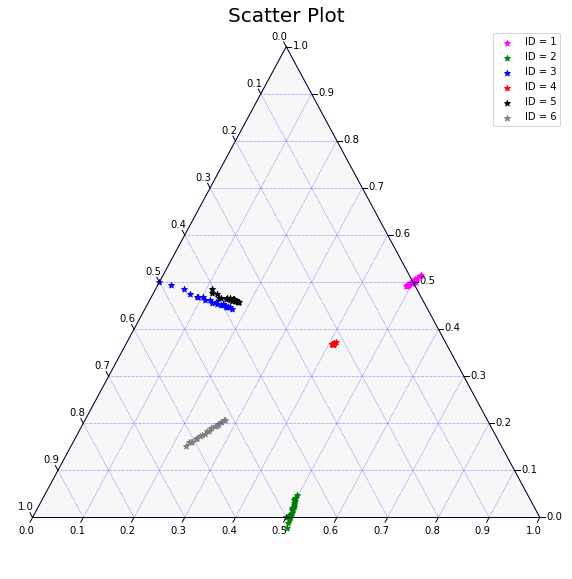

In [35]:
points_1 = []
for i in range(len(population.individual_log(1))):
    point = tuple(population.individual_log(1)['Position'][i])
    points_1.append(point)

points_2 = []
for i in range(len(population.individual_log(2))):
    point = tuple(population.individual_log(2)['Position'][i])
    points_2.append(point)

points_3 = []
for i in range(len(population.individual_log(3))):
    point = tuple(population.individual_log(3)['Position'][i])
    points_3.append(point)

points_4 = []
for i in range(len(population.individual_log(4))):
    point = tuple(population.individual_log(4)['Position'][i])
    points_4.append(point)
    
points_5 = []
for i in range(len(population.individual_log(5))):
    point = tuple(population.individual_log(5)['Position'][i])
    points_5.append(point)
    
points_6 = []
for i in range(len(population.individual_log(6))):
    point = tuple(population.individual_log(6)['Position'][i])
    points_6.append(point)  
    
# Scatter Plot
scale = 1
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 10)
# Plot a few different styles with a legend
tax.scatter(points_1, marker='*', color='magenta', label="ID = 1")
tax.scatter(points_2, marker='*', color='green', label="ID = 2")
tax.scatter(points_3, marker='*', color='blue', label="ID = 3")
tax.scatter(points_4, marker='*', color='red', label="ID = 4")
tax.scatter(points_5, marker='*', color='black', label="ID = 5")
tax.scatter(points_6, marker='*', color='grey', label="ID = 6")
tax.legend()

tax.set_title("Scatter Plot", fontsize=20)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=0.1, color="blue")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f")
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.show()